In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import *
import pandas as pd
import os

In [2]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

In [3]:
def label2rgb(label):
    # tuple은 더할 수 있다... ㅎㄷㄷ
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

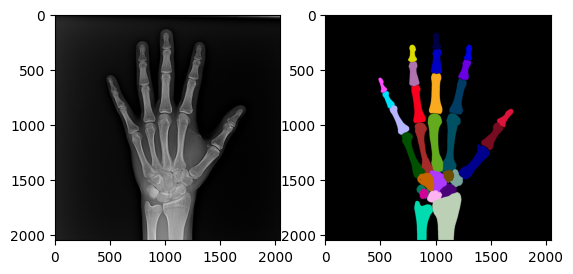

In [7]:
index = 7

df = pd.read_csv('./model_dir/unetpp_swinL/output.csv')

preds = []
rles = df.loc[:,'rle']
image_name = df.loc[index*29, 'image_name']

image_path = ''
for root, dir, file in os.walk('/opt/ml/input/data/test/DCM/'):
    for f in file:
        if f == image_name:
            image_path = os.path.join(root, f)

image = cv2.imread(image_path)
for rle in rles[index*29:index*29+29]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(image)
ax2.imshow(label2rgb(preds))

---------------------

## Augmentation check

In [4]:
import augmentations
import datasets
from torch.utils.data import DataLoader
import json
from pathlib import Path 
from easydict import EasyDict

In [5]:
fname = Path("./config.json")
with fname.open("rt") as handle:
    config = json.load(handle, object_hook=EasyDict)

In [6]:
aug = getattr(augmentations, "custom_augmentation")(resize=512)

train_dataset = getattr(datasets, "XRayDatasetFast")(config, is_train=True, transforms=aug)
# train_loader = DataLoader(
#     dataset=train_dataset,
#     batch_size=config.train_batch_size,
#     shuffle=True,
#     num_workers=config.num_workers,
#     drop_last=True,
# )

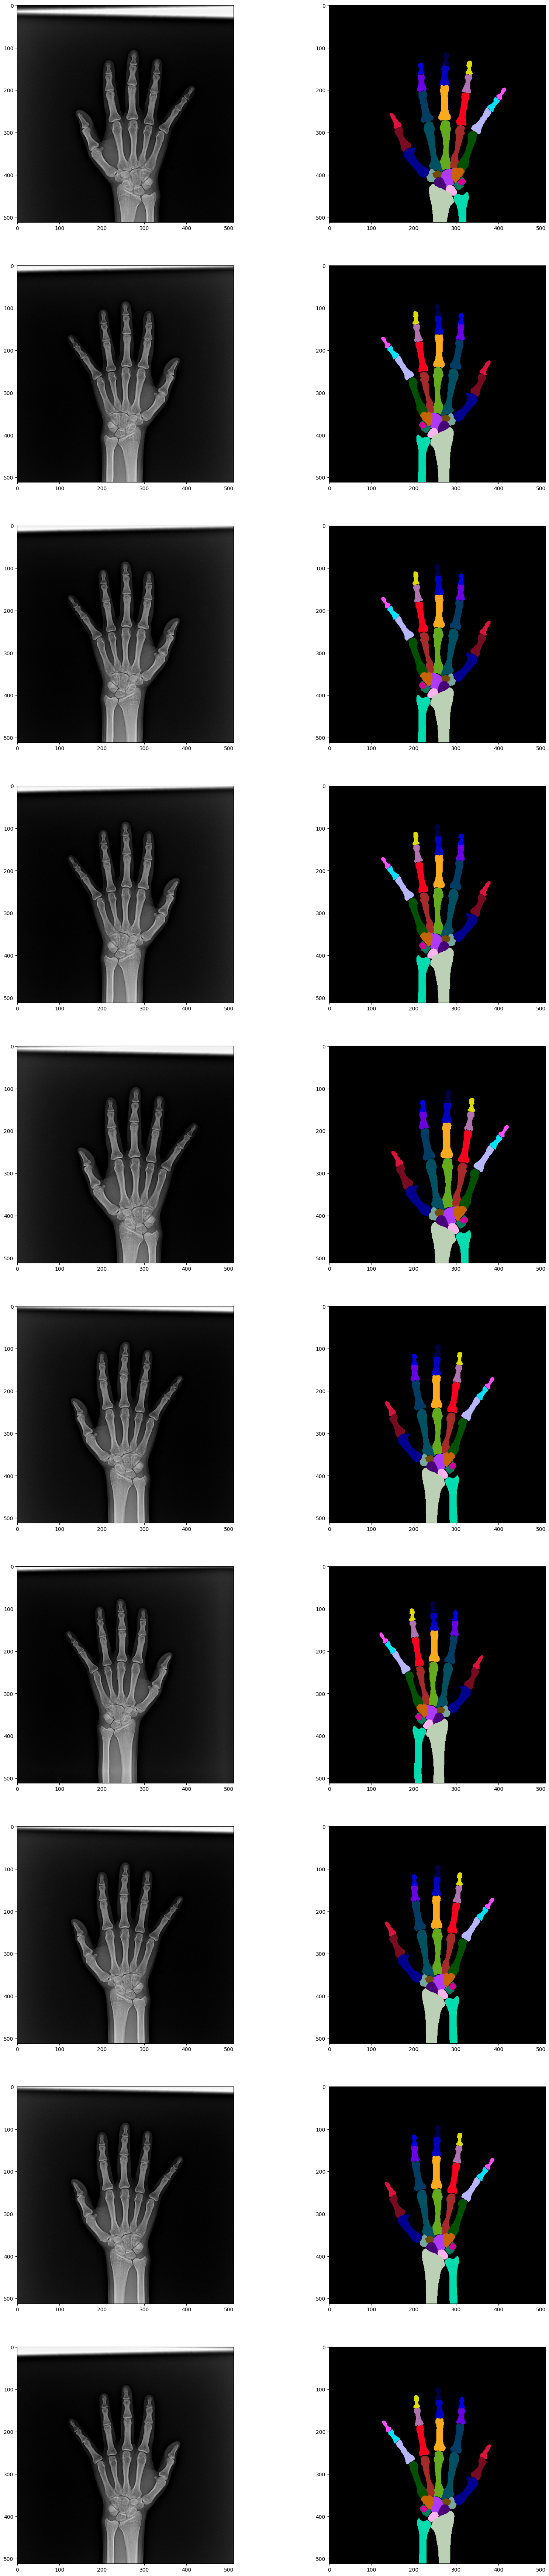

In [15]:
fig, ax = plt.subplots(10, 2)
fig.set_figwidth(20)
fig.set_figheight(90)
for i in range(10):
    sample = train_dataset[0]
    ax[i][0].imshow(sample[0].permute(1, 2, 0))
    ax[i][1].imshow(label2rgb(sample[1]))

In [47]:
from torchvision.models import resnet152

In [48]:
resnet152(pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 